Bollinger Bands&copy; are used in trend following strategies.  See https://www.bollingerbands.com for more information.

We use a moving average of the price of a security, and an upper and lower band around this price.  When the price moves above the upper band, we buy and when the price moves below the lower band we sell.

First, lets load some data.  We are going to use 15 minute prices for Pepsi stock (symbol PEP) over 1 week

In [1]:
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import os
from types import SimpleNamespace

import pyqstrat as pq

pq.set_defaults() # Set some display defaults to make dataframes and plots easier to look at

try:
    file_path = os.path.dirname(os.path.realpath(__file__)) + '/../notebooks/support/pepsi_15_min_prices.csv.gz' # If we are running from unit tests
except:
    file_path = '../notebooks/support/pepsi_15_min_prices.csv.gz'
    
prices = pd.read_csv(file_path)
prices.date = pd.to_datetime(prices.date)

Lets add the Bollinger Band functions.  Let's set the middle band to the 20 bar simple moving average of the close, and the upper and lower bands to 1 standard deviation away from the middle band.  We also a strategy context object that contains any state variables we want to use for this strategy.  The strategy passes this strategy context to functions that it calls so we can pass around any user defined state.  We also create a contract group.  A contract group is useful for futures and options where the underlying instruments expire, but we want to treat them as one virtual instrument in our code.

<Figure size 432x288 with 0 Axes>

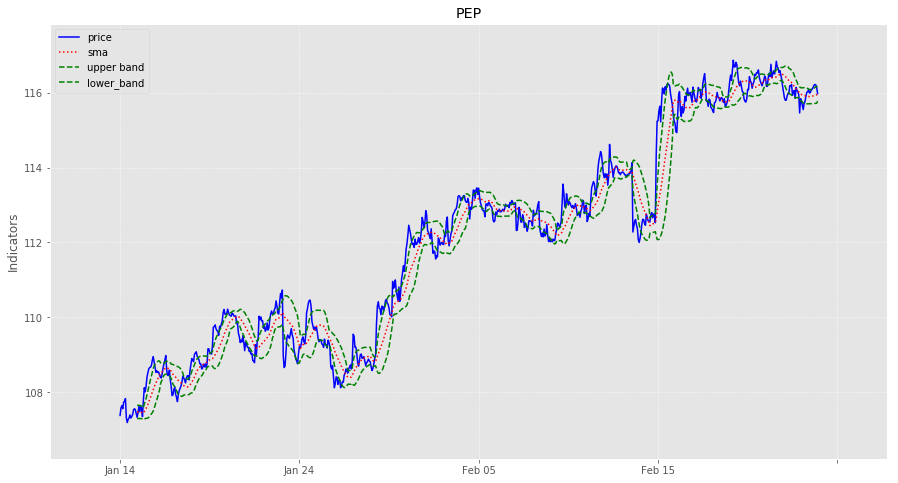

In [2]:
def sma(contract_group, timestamps, indicators, strategy_context): # simple moving average
    sma = pd.Series(indicators.c).rolling(window = strategy_context.lookback_period).mean()
    return sma.values

def band(contract_group, timestamps, indicators, strategy_context, upper):
    std = pd.Series(indicators.c).rolling(window = strategy_context.lookback_period).std()
    return indicators.sma + strategy_context.num_std * std * (1 if upper else -1)

# Each band is 1 standard deviations away from the moving average of price
# Lookback period is 20 bars
strategy_context = SimpleNamespace(num_std = 1, lookback_period = 20)
contract_group = pq.ContractGroup.create('PEP')
contract = pq.Contract.create('PEP', contract_group)

timestamps = prices.date.values

bb_indicators = SimpleNamespace(o = prices.o, h = prices.h, l = prices.l, c = prices.c)

sma_values = sma(contract, timestamps, bb_indicators, strategy_context)
bb_indicators.sma = sma_values

upper_band = lambda contract_group, timestamps, indicators, strategy_context : \
    band(contract_group, timestamps, indicators, strategy_context, upper = True)

lower_band = lambda contract_group, timestamps, indicators, strategy_context : \
    band(contract_group, timestamps, indicators, strategy_context, upper = False)

upper_band_values = upper_band(contract, timestamps, bb_indicators, strategy_context)
lower_band_values = lower_band(contract, timestamps, bb_indicators, strategy_context)

indicator_subplot = pq.Subplot([pq.TimeSeries('price', timestamps, prices.c, color = 'blue'), 
                     pq.TimeSeries('sma', timestamps, sma_values, line_type = 'dotted', color = 'red'),
                     pq.TimeSeries('upper band', timestamps, upper_band_values, line_type = 'dashed', color = 'green'),
                     pq.TimeSeries('lower_band', timestamps, lower_band_values, line_type = 'dashed', color = 'green')],
                     ylabel = 'Indicators')
plot = pq.Plot(indicator_subplot, title = 'PEP')
plot.draw();

The price, bands and the moving average are called "indicators" in pyqstrat.  Indicators are the fundamental building blocks of any strategy.

Now lets create a signal.  A signal uses marketdata and indicators and tells a strategy when to create orders.  In this case we buy when the price crosses the upper band and exit when the price crosses the moving average.  Similarly, we sell when the price crosses the lower band and exit when it crosses the moving average.  We create 4 different values of the signal, +2, -2, +1, -1 to signal all 4 of these conditions.

In [3]:
def bollinger_band_signal(contract_group, timestamps, indicators, parent_signals, strategy_context):
    # Replace nans with 0 so we don't get errors later when comparing nans to floats
    upper_band = np.nan_to_num(indicators.upper_band)
    lower_band = np.nan_to_num(indicators.lower_band)
    sma = np.nan_to_num(indicators.sma)
    
    signal = np.where(indicators.h > upper_band, 2, 0)
    signal = np.where(indicators.l < lower_band, -2, signal)
    signal = np.where((indicators.h > sma) & (signal == 0), 1, signal) # price crossed above simple moving avg but not above upper band
    signal = np.where((indicators.l < sma) & (signal == 0), -1, signal) # price crossed below simple moving avg but not below lower band
    return signal

Let's plot the signal in a subplot along with the indicators to check whether it looks reasonable

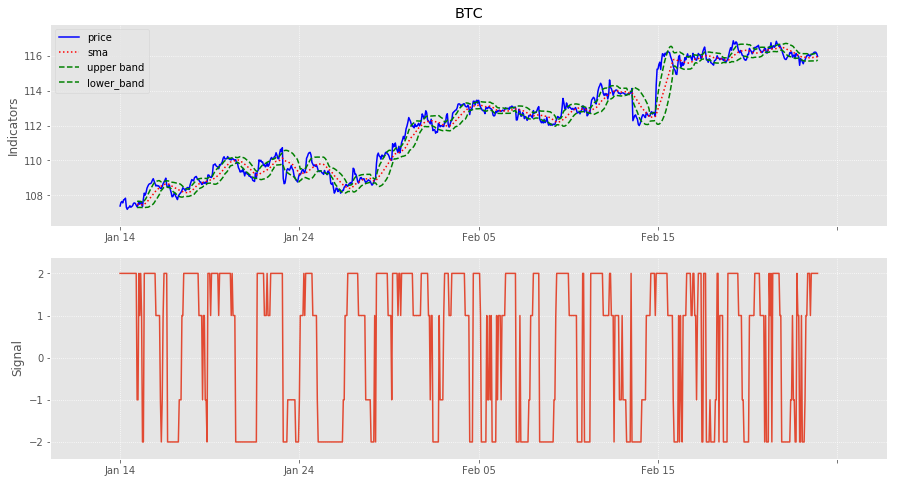

In [4]:
bb_indicators.upper_band = upper_band_values
bb_indicators.lower_band = lower_band_values
bb_indicators.sma = sma_values

signal = bollinger_band_signal(contract, timestamps, bb_indicators, None,strategy_context)
signal_subplot = pq.Subplot([pq.TimeSeries('signal', timestamps, signal)], ylabel = 'Signal')
plot = pq.Plot([indicator_subplot, signal_subplot], title = 'BTC', show_date_gaps = False)
plot.draw();

This is hard to see clearly so let's look at a smaller date range

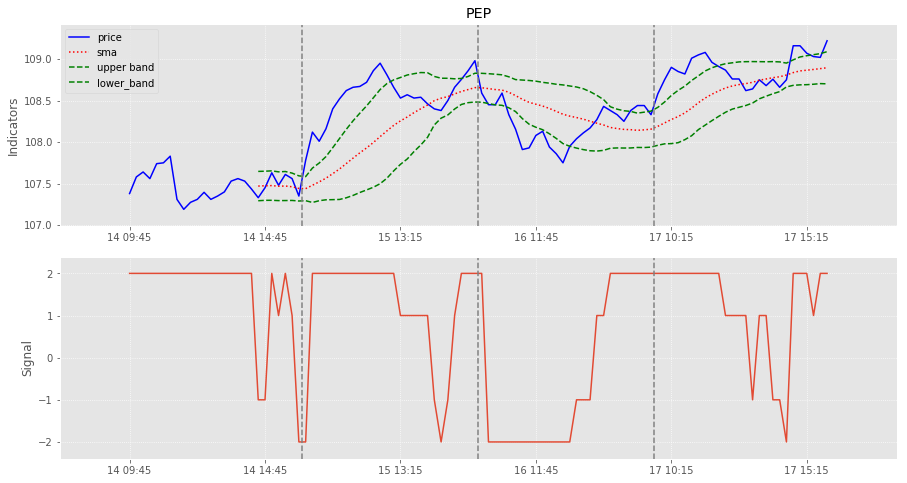

In [5]:
plot = pq.Plot([indicator_subplot, signal_subplot], title = 'PEP', date_range = ('2019-01-14', '2019-01-18'))
plot.draw();

This looks good.  The signal behaves as we would expect.

The next step is to create a trading rule.  pyqstrat will call a trading rule function when the value of it's associated signal changes value, or when we have live orders in the market that have not been filled.  A trading rule decides whether or not to take action on the signal.  If it decides to take action, it returns a list of one or more orders.  This is also where margin decisions are made, i.e. the trading rule code should calculate how much margin is needed, and not place orders if margin is exceeded.

Trading rules are usually path dependent, i.e. they cannot be vectorized like indicators and signals can, since they can depend on current position, risk, or other data which are dependent on previous orders and trades.  

Because of this path dependence, pyqstrat calls order rule functions in a loop, once per date.  This is the part of the code (along with market simulation) that you should optimize as much as you can.

Lets build the trading rule.  We will risk 10% of our current equity when going long or short.  When entering a position, we use a stop order.  This means the system will only enter if the price crosses the current close during the next bar.  We are trying to avoid a case where we cross a bollinger band in this bar but then price immediately goes the other way in the next bar, in which case we should not enter the trade.  We will ignore margin in this case for simplicity.  If we wanted to check margin, we would add code here that would check if margin would be exceeded (based on broker specific logic), and modify the order qty accordingly.

We are using predefined order reason codes when we create orders below.  Reason codes are optional strings that we use to identify why we entered an order and are useful for debugging and for plotting.  You can use an arbitrary string as a reason code.  If you later want to identify those trades in a plot, you will have to provide a mapping between your reason codes and the marker shape, size and color used for that reason code.

In [6]:
def bollinger_band_trading_rule(contract_group, i, timestamps, indicators, signal, account, strategy_context):
    timestamp = timestamps[i]
    curr_pos = account.position(contract_group, timestamp)
    signal_value = signal[i]
    risk_percent = 0.1
    close_price = indicators.c[i]
    
    contract = contract_group.get_contract('PEP')
    if contract is None:
        contract = pq.Contract.create(symbol = 'PEP', contract_group = contract_group)
    
    # if we don't already have a position, check if we should enter a trade
    if math.isclose(curr_pos, 0):
        if signal_value == 2 or signal_value == -2:
            curr_equity = account.equity(timestamp)
            order_qty = np.round(curr_equity * risk_percent / close_price * np.sign(signal_value))
            trigger_price = close_price
            reason_code = pq.ReasonCode.ENTER_LONG if order_qty > 0 else pq.ReasonCode.ENTER_SHORT
            return [pq.StopLimitOrder(contract, timestamp, order_qty, trigger_price, reason_code = reason_code)]
        
    else: # We have a current position, so check if we should exit
        if (curr_pos > 0 and signal_value == -1) or (curr_pos < 0 and signal_value == 1):
            order_qty = -curr_pos
            reason_code = pq.ReasonCode.EXIT_LONG if order_qty < 0 else pq.ReasonCode.EXIT_SHORT
            return [pq.MarketOrder(contract, timestamp, order_qty, reason_code = reason_code)]
    return []

We need to write one more function, a market simulator.  The market simulator decides whether open orders will be filled, and at what price.  This is where you would add slippage, commissions and fees.  You can add a different market simulator for each symbol, since liquidity and market rules are clearly different when trading an IBM stock on NYSE versus trading a E-mini future on CME.  pyqstrat will call the market simulator on the next bar after you add an order since you obviously cannot get filled using prices you already saw and used to construct your order.  In this simulator we fill buy market orders half way between the open and the high for the current bar, and we fill sells half way between the open and the low. Stop orders are filled halfway between the trigger price and the high or low.  Lets assume commission of $5 per contract and no other fees.

In [7]:
def market_simulator(orders, i, timestamps, indicators, signals, strategy_context):
    trades = []
    timestamp = timestamps[i]
    
    o, h, l, c = indicators.o[i], indicators.h[i], indicators.l[i], indicators.c[i]
    
    for order in orders:
        trade_price = np.nan
        
        if isinstance(order, pq.MarketOrder):
            trade_price = 0.5 * (o + h) if order.qty > 0 else 0.5 * (o + l)
        elif isinstance(order, pq.StopLimitOrder):
            if (order.qty > 0 and h > order.trigger_price) or (order.qty < 0 and l < order.trigger_price): # A stop order
                trade_price = 0.5 * (order.trigger_price + h) if order.qty > 0 else 0.5 * (order.trigger_price + l)
        else:
            raise Exception(f'unexpected order type: {order}')
            
        if np.isnan(trade_price): continue
            
        trade = pq.Trade(order.contract, timestamp, order.qty, trade_price, order = order, commission = order.qty * 5, fee = 0)
        order.status = 'filled'
                           
        trades.append(trade)
                           
    return trades

We also need a price function that the strategy calls when it needs to compute P&L, for example when you ask for current equity in trading rule code.

In [8]:
def get_price(contract, timestamps, i, strategy_context):
    return prices.c[i]

Now lets create the strategy and run it.  

In [9]:
def build_strategy(contract_group, strategy_context):
    strategy = pq.Strategy(timestamps, [contract_group], get_price, strategy_context = strategy_context)
    
    strategy.add_indicator('o', prices.o.values)
    strategy.add_indicator('c', prices.c.values)
    strategy.add_indicator('h', prices.h.values)
    strategy.add_indicator('l', prices.l.values)
    strategy.add_indicator('sma', sma, depends_on = ['c'])
    strategy.add_indicator('upper_band', upper_band, depends_on = ['c', 'sma'])
    strategy.add_indicator('lower_band', lower_band, depends_on = ['c', 'sma'])
    
    strategy.add_signal('bb_signal', bollinger_band_signal, depends_on_indicators = ['h', 'l', 'sma', 'upper_band', 'lower_band'])

    # ask pqstrat to call our trading rule when the signal has one of the values [-2, -1, 1, 2]
    strategy.add_rule('bb_trading_rule', bollinger_band_trading_rule, 
                      signal_name = 'bb_signal', sig_true_values = [-2, -1, 1, 2])

    strategy.add_market_sim(market_simulator)
    
    return strategy


strategy_context = SimpleNamespace(lookback_period = 20, num_std = 1)
strategy = build_strategy(contract_group, strategy_context)
strategy.run()

Lets plot our strategy and our portfolio and evaluate our returns  

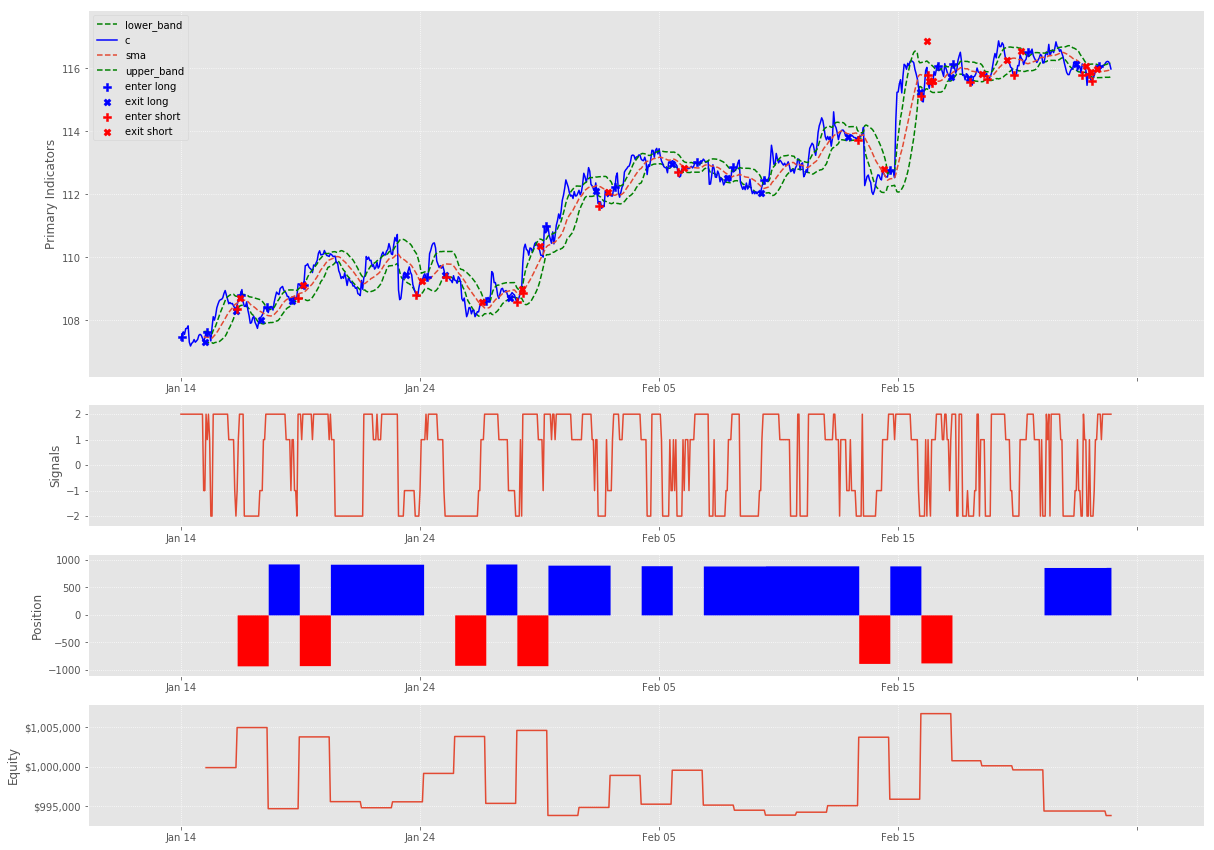

In [10]:
strategy.plot(primary_indicators = ['c', 'sma', 'upper_band', 'lower_band'],
                indicator_properties = {'sma' : {'line_type' : '--'},
                                        'upper_band' : {'line_type' : '--', 'color': 'green'},
                                        'lower_band' : {'line_type' : '--', 'color': 'green'},
                                        'c' : {'color' : 'blue'},
                                       })

,gmean,amean,std,shrp,srt,calmar,mar,mdd_pct,mdd_dates,dd_3y_pct,dd_3y_timestamps,up_dwn,2019
,-0.0517,-0.0001936,0.005842,-0.526,-0.8729,3.78,3.78,-0.0129,2019-02-15/2019-02-26,-0.0129,2019-02-15/2019-02-26,13/16/0.448,-0.0517


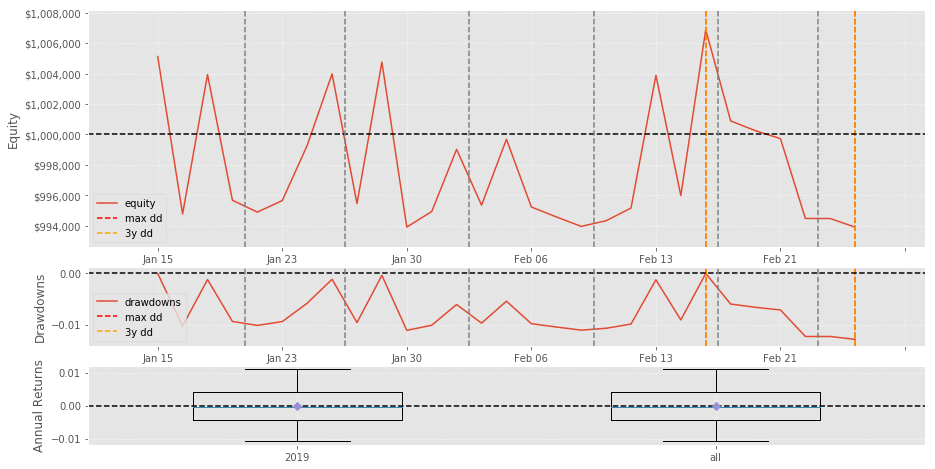

In [11]:
strategy.evaluate_returns();

Note that we calculate P&L once a day so the equity line produced when we evaluate returns has fewer points than the equity line when we plot the strategy itself.

We can also put multiple strategies together in a portfolio and run them simultaneously.  Lets add two instances of the Bollinger Band strategy with two different lookback periods and standard deviation thresholds.

In [12]:
from pyqstrat.notebooks.support.build_example_strategy import build_example_strategy

strategy1 = build_example_strategy(SimpleNamespace(lookback_period = 5, num_std = 1))
strategy2 = build_example_strategy(SimpleNamespace(lookback_period = 10, num_std = 2))
portfolio = pq.Portfolio()
portfolio.add_strategy('bb_strategy_1', strategy1)
portfolio.add_strategy('bb_strategy_2', strategy2)
portfolio.run()

Lets now plot the output of the two strategies as well as the portfolio output.  The portfolio returns will be the sum of the returns of the 2 strategies.

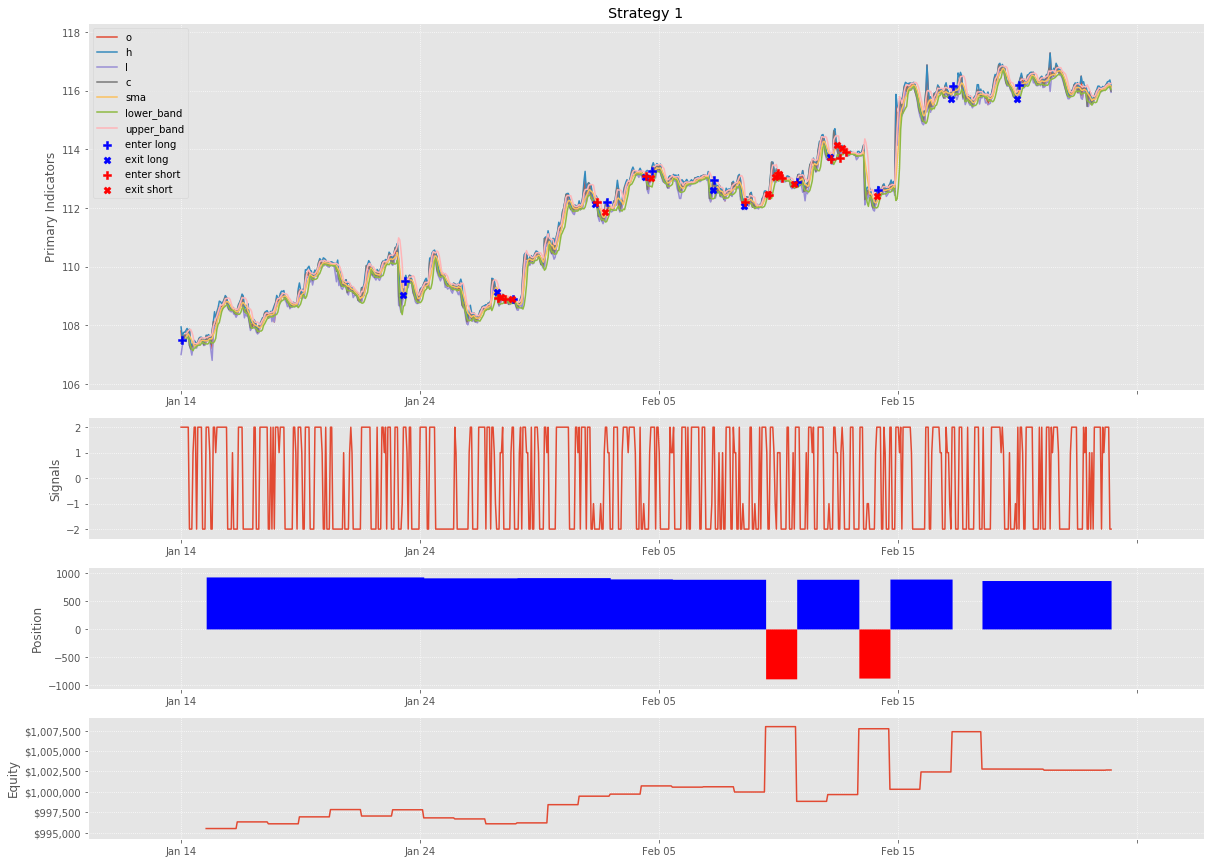

In [13]:
strategy1.plot(title = 'Strategy 1')

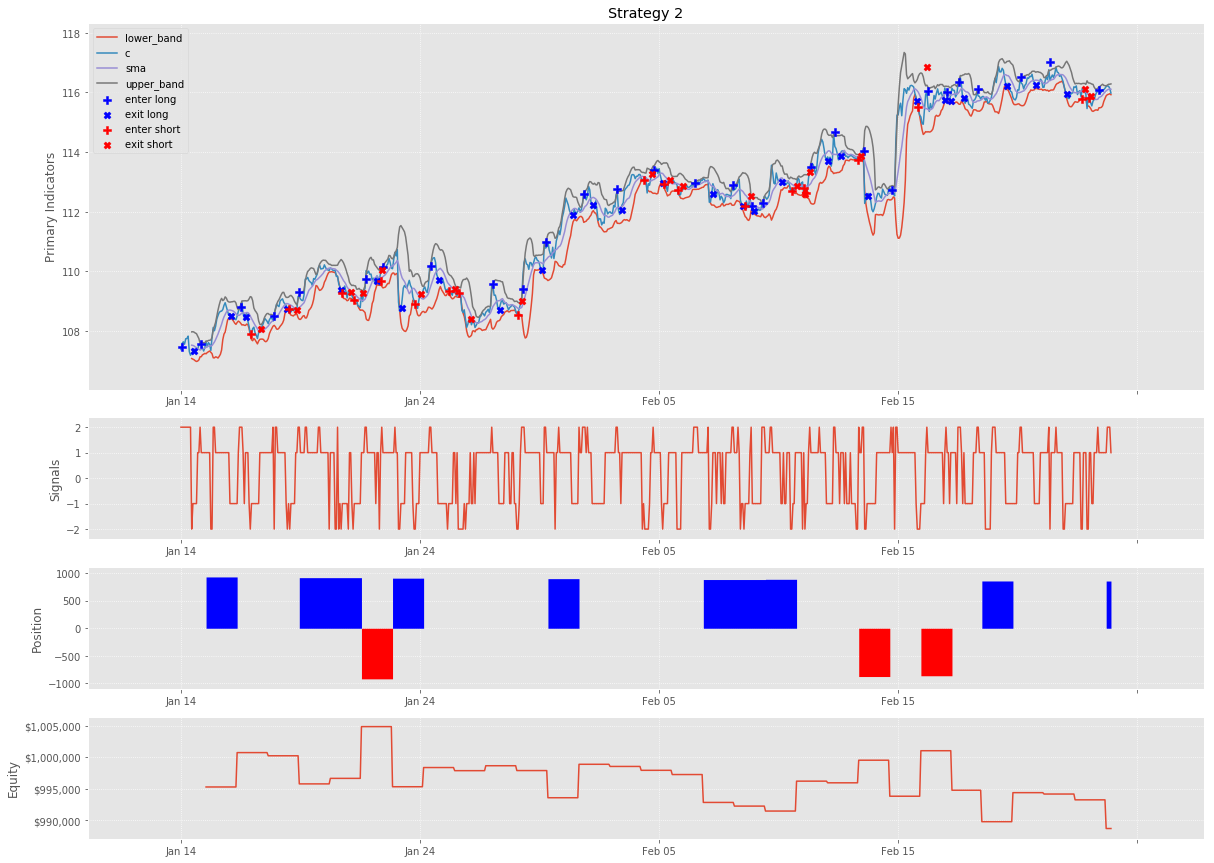

In [14]:
strategy2.plot(title = 'Strategy 2', primary_indicators = ['c', 'sma', 'upper_band', 'lower_band']);

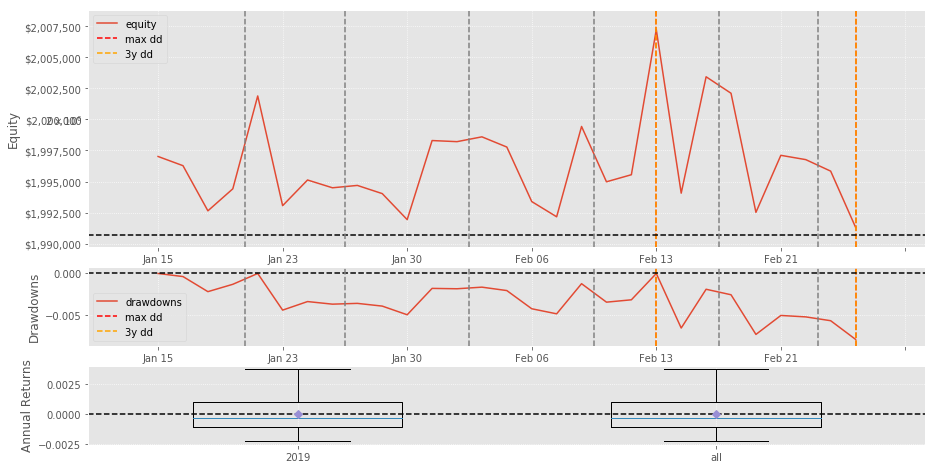

In [15]:
portfolio.plot()

,gmean,amean,std,shrp,srt,calmar,mar,mdd_pct,mdd_dates,dd_3y_pct,dd_3y_timestamps,up_dwn,2019
,-0.05588,-0.0002192,0.004225,-0.8238,-1.385,3.432,3.432,-0.0161,2019-01-22/2019-02-26,-0.0161,2019-01-22/2019-02-26,10/19/0.345,-0.05588


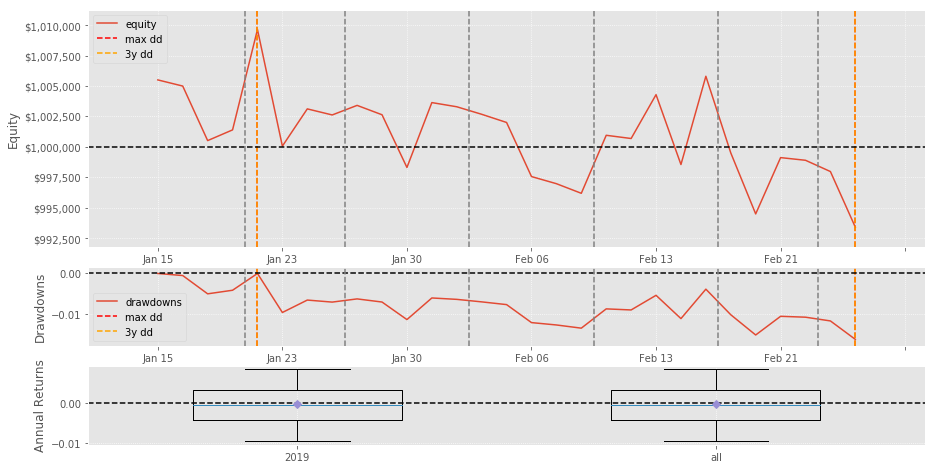

In [16]:
strategy2.evaluate_returns();